<a href="https://colab.research.google.com/github/spouladchang/Mountain-Car-RL-Optimization/blob/main/1_MountainCar_Q_Learning_Discretization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MountainCar-v0 Q-Learning Implementation

This notebook implements a **tabular Q-Learning** agent to solve the classic MountainCar-v0 challenge from OpenAI Gym. The objective is to drive an underpowered car up a steep hill by building momentum through strategic back-and-forth movements.

## Problem Description

In the MountainCar environment:
- The car starts in a valley between two hills
- The goal is to reach the flag at position ≥ 0.5 on the right hill
- The engine is too weak to drive straight up the hill
- The agent must learn to build momentum by oscillating back and forth

**State Space**: Continuous [position, velocity]
- Position: [-1.2, 0.6]
- Velocity: [-0.07, 0.07]

**Action Space**: Discrete {0, 1, 2}
- 0: Push left
- 1: No push
- 2: Push right

**Reward**: -1 for each time step until the goal is reached

## 1. Import Libraries

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import time
import os
from datetime import datetime

# Environment name
ENV_NAME = 'MountainCar-v0'

## 2. Configuration & Hyperparameters


### Hyperparameters (Optimized through Grid Search)

These values were systematically tuned to maximize success rate:

- **Bucket Size**: 25×25 (625 states)
  - Better precision than 20×20
  - Not too large (still converges reasonably fast)
  
- **Learning Rate (α)**: 0.2 → 0.01
  - Higher initial rate (0.2) for faster early learning
  - Higher minimum (0.01 vs 0.001) maintains adaptability
  - Slower decay (0.9998) keeps learning active longer
  
- **Discount Factor (γ)**: 0.99
  - Standard value for episodic tasks
  
- **Epsilon (ε)**: 1.0 → 0.01
  - Slower decay (0.9998 vs 0.9995) crucial for sparse rewards
  - Agent explores for longer before committing to policy
  
- **Episodes**: 7000
  - Sparse reward environment needs more exploration time
  - At episode 7000: ε≈0.18 (still exploring), LR≈0.025 (still learning)

In [2]:
# State space discretization
LOWER_BOUNDS = np.array([-1.2, -0.07])
UPPER_BOUNDS = np.array([0.6, 0.07])
BUCKETS = (25, 25)

# Hyperparameters - OPTIMIZED
LEARNING_RATE = 0.2
MIN_LEARNING_RATE = 0.01
LR_DECAY = 0.9998

DISCOUNT_FACTOR = 0.99

EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY = 0.9998

EPISODES = 7000

## 3. Environment Inspection

Let's examine the environment to understand the state and action spaces.

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
  - Position range: [-1.20, 0.60]
  - Velocity range: [-0.07, 0.07]

Action Space: Discrete(3)
  - 0: Push left
  - 1: No push
  - 2: Push right


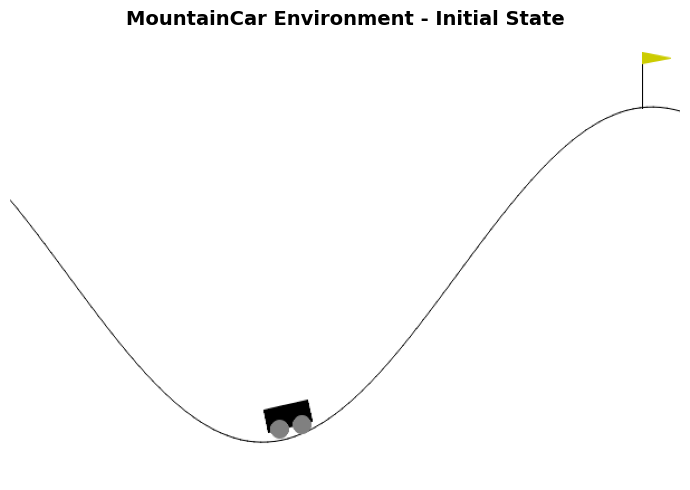

In [3]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
state, info = env.reset()

print(f"Observation Space: {env.observation_space}")
print(f"  - Position range: [{env.observation_space.low[0]:.2f}, {env.observation_space.high[0]:.2f}]")
print(f"  - Velocity range: [{env.observation_space.low[1]:.2f}, {env.observation_space.high[1]:.2f}]")
print(f"\nAction Space: {env.action_space}")
print(f"  - 0: Push left")
print(f"  - 1: No push")
print(f"  - 2: Push right")

# Visualize initial state
plt.figure(figsize=(8, 5))
plt.imshow(env.render())
plt.axis('off')
plt.title("MountainCar Environment - Initial State", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

env.close()

## 4. Core Functions

### Discretization Strategy

We convert continuous states to discrete grid indices using vectorized NumPy operations for efficiency.

**Process**:
1. Normalize state values to [0, 1] range
2. Scale to bucket indices [0, BUCKETS-1]
3. Clip to ensure valid indices

**Example**: If car is at position=-0.5, velocity=0.02 with 20×20 grid:
- Position index: (-0.5 - (-1.2)) / (0.6 - (-1.2)) × 20 ≈ 7
- Velocity index: (0.02 - (-0.07)) / (0.07 - (-0.07)) × 20 ≈ 12
- Discrete state: (7, 12)

### Action Selection

We use **Epsilon-Greedy** strategy:
- With probability ε: choose random action (exploration)
- With probability 1-ε: choose best action from Q-table (exploitation)

In [4]:
def discretize(state):
    """
    Convert continuous state to discrete bucket indices.
    Uses vectorized operations for efficiency.
    """
    scaling = (state - LOWER_BOUNDS) / (UPPER_BOUNDS - LOWER_BOUNDS)
    indices = (scaling * BUCKETS).astype(int)
    return tuple(np.clip(indices, 0, np.array(BUCKETS) - 1))


def choose_action(q_table, state, action_space, epsilon):
    """
    Epsilon-greedy action selection.
    Balances exploration (random) and exploitation (greedy).
    """
    if np.random.random() < epsilon:
        return action_space.sample()  # Explore
    return np.argmax(q_table[state])  # Exploit

## 5. Training Algorithm

### Q-Learning Update Rule (Bellman Equation)

$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'} Q(s',a') - Q(s,a)\right]$$

Where:
- $Q(s,a)$: Q-value for state-action pair
- $\alpha$: Learning rate (how much to update)
- $r$: Immediate reward (-1 per step)
- $\gamma$: Discount factor (importance of future rewards)
- $s'$: Next state
- $\max_{a'} Q(s',a')$: Best Q-value from next state

### Terminal State Handling (Important Fix!)

When the episode ends (car reaches goal or timeout), there is **no next state**, so:
$$Q(s,a) \leftarrow Q(s,a) + \alpha [r - Q(s,a)]$$

**Why?** If we bootstrap from a non-existent next state, we corrupt the Q-values.

### Metrics Tracked

1. **Episode Reward**: Total reward per episode (shows task performance)
2. **Max Position**: Highest point reached (shows physical progress)
   - **Why track this?** Helps us understand if agent is learning to climb higher
   - Early episodes: max position ≈ -0.4 (stuck in valley)
   - Late episodes: max position ≈ 0.5+ (reaches goal)
3. **Q-Value Changes**: Largest Q-update per episode (shows learning stability)
   - Large changes early: Agent learning new information
   - Small changes late: Values converging (stable policy)

In [5]:
def train_agent(env, episodes=EPISODES):
    """
    Train Q-Learning agent.

    Returns:
        q_table: Learned Q-values
        policy: Optimal policy (best action per state)
        metrics: Training history
    """
    # Initialize Q-table with zeros
    q_table = np.zeros(BUCKETS + (env.action_space.n,))

    # Initialize hyperparameters
    lr = LEARNING_RATE
    epsilon = EPSILON

    # Tracking metrics
    rewards_per_episode = []
    max_positions = []
    q_value_changes = []

    print("="*70)
    print("TRAINING STARTED")
    print("="*70)
    print(f"Episodes: {episodes}")
    print(f"State Space: {BUCKETS[0]} × {BUCKETS[1]} = {BUCKETS[0]*BUCKETS[1]} discrete states")
    print(f"Action Space: {env.action_space.n} actions")
    print("="*70)

    start_time = time.time()

    for episode in range(episodes):
        # Reset environment
        state, _ = env.reset()
        state = discretize(state)

        episode_reward = 0
        max_position = -1.2
        max_change = 0
        done = False

        # Episode loop
        while not done:
            # Choose action
            action = choose_action(q_table, state, env.action_space, epsilon)

            # Take action
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state_discrete = discretize(next_obs)
            done = terminated or truncated

            # Q-Learning update
            old_value = q_table[state][action]

            # Terminal state handling (critical for convergence)
            if terminated:
                next_value = 0  # No future rewards at goal
            else:
                next_value = np.max(q_table[next_state_discrete])

            # Bellman equation
            new_value = old_value + lr * (reward + DISCOUNT_FACTOR * next_value - old_value)
            q_table[state][action] = new_value

            # Track metrics
            change = abs(new_value - old_value)
            max_change = max(max_change, change)
            max_position = max(max_position, next_obs[0])
            episode_reward += reward

            # Update state
            state = next_state_discrete

        # Store episode metrics
        rewards_per_episode.append(episode_reward)
        max_positions.append(max_position)
        q_value_changes.append(max_change)

        # Decay hyperparameters
        epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
        lr = max(MIN_LEARNING_RATE, lr * LR_DECAY)

        # Print progress
        if (episode + 1) % 500 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            avg_position = np.mean(max_positions[-100:])
            print(f"Episode {episode+1:4d} | "
                  f"Avg Reward: {avg_reward:6.1f} | "
                  f"Avg Max Pos: {avg_position:+.2f} | "
                  f"ε: {epsilon:.4f} | "
                  f"LR: {lr:.4f}")

    training_time = time.time() - start_time

    print("="*70)
    print("TRAINING COMPLETED")
    print("="*70)
    print(f"Total Time: {training_time:.2f}s")
    print(f"Time per Episode: {training_time/episodes:.3f}s")
    print("="*70)

    # Extract policy
    policy = np.argmax(q_table, axis=2)

    return q_table, policy, {
        'rewards': rewards_per_episode,
        'positions': max_positions,
        'q_changes': q_value_changes
    }

## 6. Run Training

Now let's train the agent for 7000 episodes.

In [6]:
# Create environment
train_env = gym.make(ENV_NAME)

# Check if pre-trained weights exist
weights_file = 'trained_weights_discretization.npz'

if os.path.exists(weights_file):
    print("="*70)
    print("LOADING PRE-TRAINED WEIGHTS")
    print("="*70)
    print(f"Found existing weights: {weights_file}")
    print("Loading... (set RETRAIN=True to train from scratch)")
    print("="*70)

    # Load weights
    data = np.load(weights_file, allow_pickle=True)
    q_table = data['q_table']
    policy = data['policy']
    metrics = {
        'rewards': data['rewards'].tolist(),
        'positions': data['positions'].tolist(),
        'q_changes': data['q_changes'].tolist()
    }

    print(f"✅ Loaded Q-table shape: {q_table.shape}")
    print(f"✅ Loaded training history: {len(metrics['rewards'])} episodes")
    print()

else:
    print("="*70)
    print("NO PRE-TRAINED WEIGHTS FOUND")
    print("="*70)
    print("Starting training from scratch...")
    print("="*70)
    print()

    # Train agent
    q_table, policy, metrics = train_agent(train_env, episodes=EPISODES)

# Close environment
train_env.close()

NO PRE-TRAINED WEIGHTS FOUND
Starting training from scratch...

TRAINING STARTED
Episodes: 7000
State Space: 25 × 25 = 625 discrete states
Action Space: 3 actions
Episode  500 | Avg Reward: -200.0 | Avg Max Pos: -0.34 | ε: 0.9048 | LR: 0.1810
Episode 1000 | Avg Reward: -200.0 | Avg Max Pos: -0.27 | ε: 0.8187 | LR: 0.1637
Episode 1500 | Avg Reward: -200.0 | Avg Max Pos: -0.21 | ε: 0.7408 | LR: 0.1482
Episode 2000 | Avg Reward: -200.0 | Avg Max Pos: -0.14 | ε: 0.6703 | LR: 0.1341
Episode 2500 | Avg Reward: -200.0 | Avg Max Pos: -0.12 | ε: 0.6065 | LR: 0.1213
Episode 3000 | Avg Reward: -200.0 | Avg Max Pos: -0.01 | ε: 0.5488 | LR: 0.1098
Episode 3500 | Avg Reward: -199.7 | Avg Max Pos: +0.05 | ε: 0.4966 | LR: 0.0993
Episode 4000 | Avg Reward: -199.9 | Avg Max Pos: +0.11 | ε: 0.4493 | LR: 0.0899
Episode 4500 | Avg Reward: -198.7 | Avg Max Pos: +0.12 | ε: 0.4065 | LR: 0.0813
Episode 5000 | Avg Reward: -196.0 | Avg Max Pos: +0.32 | ε: 0.3678 | LR: 0.0736
Episode 5500 | Avg Reward: -195.0 | A

## 7. Performance Evaluation

Let's test the trained policy over 100 episodes to measure its success rate.

In [7]:
def test_agent(policy, num_episodes=100, verbose=True):
    """
    Test trained policy and return statistics.
    """
    test_env = gym.make(ENV_NAME)

    successes = 0
    total_rewards = []
    successful_steps = []

    for ep in range(num_episodes):
        state, _ = test_env.reset()
        state = discretize(state)

        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < 200:
            action = policy[state]
            next_state, reward, terminated, truncated, _ = test_env.step(action)

            state = discretize(next_state)
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        total_rewards.append(episode_reward)

        if next_state[0] >= 0.5:
            successes += 1
            successful_steps.append(steps)
            if verbose and ep < 10:
                print(f"  Test {ep+1:2d}: ✅ SUCCESS | Reward: {episode_reward:6.1f} | Steps: {steps:3d}")
        elif verbose and ep < 10:
            print(f"  Test {ep+1:2d}: ❌ FAILED  | Reward: {episode_reward:6.1f} | Steps: {steps:3d}")

    test_env.close()

    success_rate = (successes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(successful_steps) if successful_steps else 0

    return success_rate, avg_reward, avg_steps


# Test the trained agent
print("\n" + "="*70)
print("TESTING TRAINED POLICY")
print("="*70)
print("\nSample Episodes (first 10):")
print("-"*70)

success_rate, avg_reward, avg_steps = test_agent(policy, num_episodes=100, verbose=True)

print("\n" + "="*70)
print("FINAL RESULTS (100 episodes)")
print("="*70)
print(f"Success Rate:        {success_rate:5.1f}%")
print(f"Average Reward:      {avg_reward:6.1f}")
if avg_steps > 0:
    print(f"Average Steps:       {avg_steps:6.1f}")
print("="*70)


TESTING TRAINED POLICY

Sample Episodes (first 10):
----------------------------------------------------------------------
  Test  1: ✅ SUCCESS | Reward: -156.0 | Steps: 156
  Test  2: ✅ SUCCESS | Reward: -155.0 | Steps: 155
  Test  3: ✅ SUCCESS | Reward: -172.0 | Steps: 172
  Test  4: ✅ SUCCESS | Reward: -163.0 | Steps: 163
  Test  5: ✅ SUCCESS | Reward: -158.0 | Steps: 158
  Test  6: ✅ SUCCESS | Reward: -164.0 | Steps: 164
  Test  7: ✅ SUCCESS | Reward: -160.0 | Steps: 160
  Test  8: ✅ SUCCESS | Reward: -175.0 | Steps: 175
  Test  9: ✅ SUCCESS | Reward: -155.0 | Steps: 155
  Test 10: ✅ SUCCESS | Reward: -157.0 | Steps: 157

FINAL RESULTS (100 episodes)
Success Rate:        100.0%
Average Reward:      -158.9
Average Steps:        158.9


## 8. Visualization

### Understanding the Three Plots

1. **Episode Rewards** (Top)
   - Shows cumulative reward per episode
   - Early: -200 (timeout, no success)
   - Late: -110 to -170 (reaching goal faster)
   - **Interpretation**: Upward trend = agent improving

2. **Maximum Position Reached** (Middle)
   - **Why this metric?** Helps visualize physical progress toward goal
   - Early: ~-0.4 to -0.2 (stuck in valley)
   - Mid: ~0.0 to 0.3 (climbing right hill)
   - Late: ~0.5+ (reaching flag)
   - **Interpretation**: Shows agent learning to climb higher
   - **Key insight**: Even failed episodes show progress if position increases

3. **Q-Value Changes** (Bottom)
   - Measures maximum Q-value update per episode (log scale)
   - Early: Large changes (rapid learning)
   - Late: Small changes (values stabilizing)
   - **Interpretation**: Decreasing trend = convergence to optimal policy
   - **Why log scale?** Shows fine-grained changes in later episodes


Generating training visualization...
✅ Saved plot: assets/qlearning_training.png


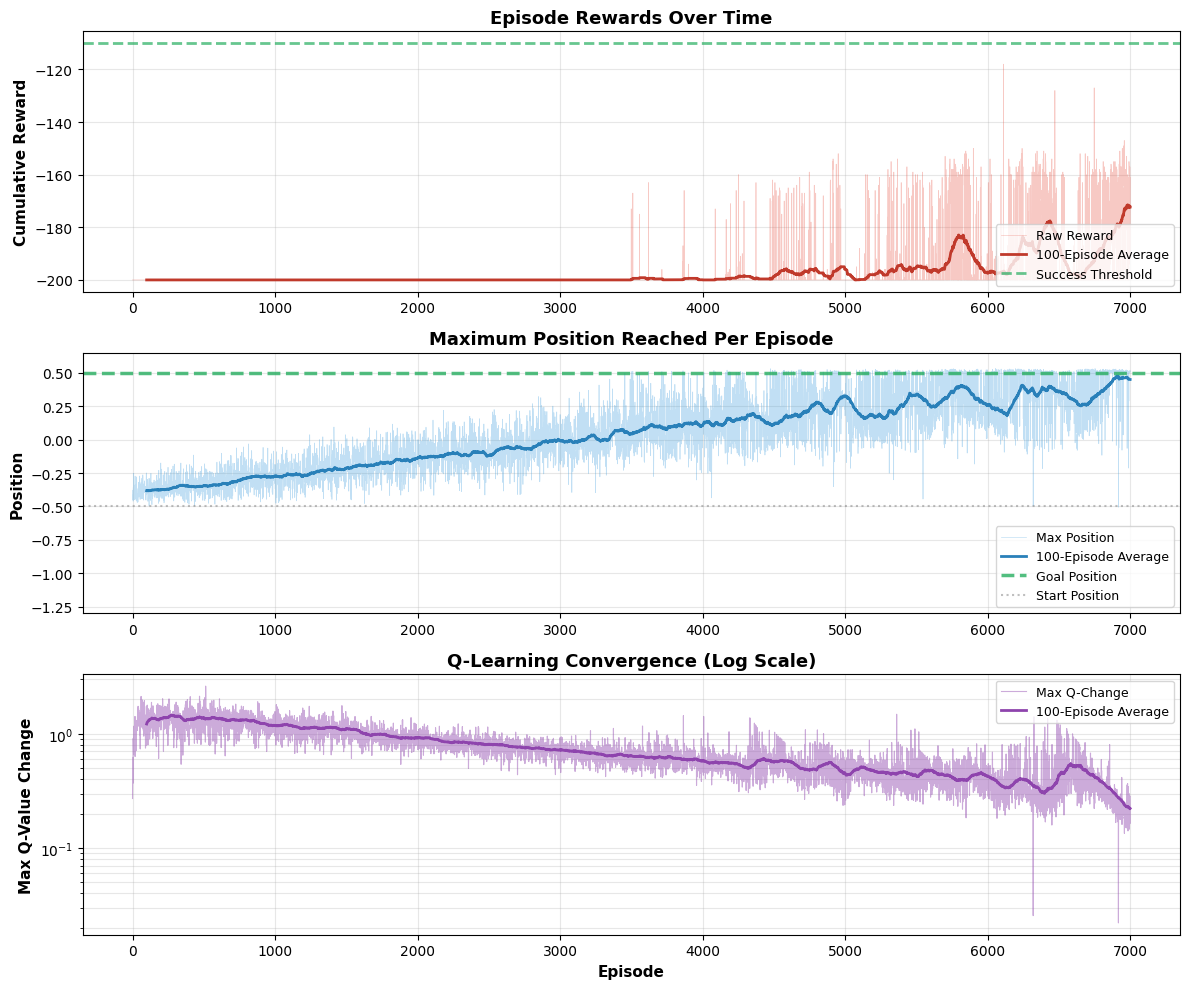

In [8]:
def plot_results(metrics, save_path=None):
    """Visualize training metrics with three informative plots."""
    rewards = metrics['rewards']
    positions = metrics['positions']
    q_changes = metrics['q_changes']

    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    window = 100

    # Plot 1: Episode Rewards
    axes[0].plot(rewards, alpha=0.3, color='#e74c3c', linewidth=0.5, label='Raw Reward')
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0].plot(range(window-1, len(rewards)), smoothed,
                     color='#c0392b', linewidth=2, label=f'{window}-Episode Average')
    axes[0].axhline(y=-110, color='#27ae60', linestyle='--', linewidth=2,
                    label='Success Threshold', alpha=0.7)
    axes[0].set_ylabel('Cumulative Reward', fontsize=11, fontweight='bold')
    axes[0].set_title('Episode Rewards Over Time', fontsize=13, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=9)
    axes[0].grid(alpha=0.3)

    # Plot 2: Maximum Position
    axes[1].plot(positions, alpha=0.3, color='#3498db', linewidth=0.5, label='Max Position')
    if len(positions) >= window:
        smoothed = np.convolve(positions, np.ones(window)/window, mode='valid')
        axes[1].plot(range(window-1, len(positions)), smoothed,
                     color='#2980b9', linewidth=2, label=f'{window}-Episode Average')
    axes[1].axhline(y=0.5, color='#27ae60', linestyle='--', linewidth=2.5,
                    label='Goal Position', alpha=0.8)
    axes[1].axhline(y=-0.5, color='gray', linestyle=':', linewidth=1.5,
                    label='Start Position', alpha=0.5)
    axes[1].set_ylabel('Position', fontsize=11, fontweight='bold')
    axes[1].set_title('Maximum Position Reached Per Episode', fontsize=13, fontweight='bold')
    axes[1].legend(loc='lower right', fontsize=9)
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([-1.3, 0.65])

    # Plot 3: Q-Value Convergence
    axes[2].plot(q_changes, alpha=0.5, color='#9b59b6', linewidth=0.8, label='Max Q-Change')
    if len(q_changes) >= window:
        smoothed = np.convolve(q_changes, np.ones(window)/window, mode='valid')
        axes[2].plot(range(window-1, len(q_changes)), smoothed,
                     color='#8e44ad', linewidth=2, label=f'{window}-Episode Average')
    axes[2].set_xlabel('Episode', fontsize=11, fontweight='bold')
    axes[2].set_ylabel('Max Q-Value Change', fontsize=11, fontweight='bold')
    axes[2].set_title('Q-Learning Convergence (Log Scale)', fontsize=13, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].legend(loc='upper right', fontsize=9)
    axes[2].grid(alpha=0.3, which='both')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot: {save_path}")

    plt.show()


# Generate and save plots
print("\nGenerating training visualization...")
plot_results(metrics, save_path='assets/qlearning_training.png')

## 9. Agent Animation

Let's visualize the trained agent solving the environment.

In [9]:
def create_animation(policy):
    """
    Create animation showing trained agent in action.
    """
    env = gym.make(ENV_NAME, render_mode='rgb_array')
    state, _ = env.reset()
    state = discretize(state)

    frames = []
    episode_reward = 0
    steps = 0
    done = False

    while not done and steps < 200:
        frames.append(env.render())
        action = policy[state]
        next_obs, reward, terminated, truncated, _ = env.step(action)

        state = discretize(next_obs)
        episode_reward += reward
        steps += 1
        done = terminated or truncated

    env.close()

    # Create animation
    fig = plt.figure(figsize=(6, 4))
    plt.axis('off')
    img = plt.imshow(frames[0])

    success = "SUCCESS" if next_obs[0] >= 0.5 else "FAILED"
    plt.title(f"Trained Agent | {success} | Reward: {episode_reward:.0f} | Steps: {steps}",
              fontsize=12, fontweight='bold')

    def animate(i):
        img.set_array(frames[i])
        return [img]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    plt.close()

    return HTML(anim.to_jshtml())


# Create and display animation
print("\nGenerating animation...")
display(create_animation(policy))


Generating animation...


## 10. Save Trained Weights

Save the trained Q-table, policy, and training metrics for future use.
All outputs are saved in a compressed `.npz` file.

In [10]:
# Save all training outputs
weights_file = 'trained_weights_discretization.npz'

print("="*70)
print("SAVING TRAINED WEIGHTS")
print("="*70)

# Save without Python objects (no allow_pickle needed)
np.savez_compressed(
    weights_file,
    q_table=q_table,
    policy=policy,
    rewards=np.array(metrics['rewards']),
    positions=np.array(metrics['positions']),
    q_changes=np.array(metrics['q_changes'])
)

print(f"✅ Saved: {weights_file}")
print(f"   - Q-table shape: {q_table.shape}")
print(f"   - Policy shape: {policy.shape}")
print(f"   - Training episodes: {len(metrics['rewards'])}")

# Get file size
file_size = os.path.getsize(weights_file) / 1024  # KB
print(f"   - File size: {file_size:.2f} KB")

print("="*70)
print()

# Show how to load weights
print("To load these weights later:")
print("─"*70)
print("data = np.load('trained_weights_discretization.npz')")
print("q_table = data['q_table']")
print("policy = data['policy']")
print("rewards = data['rewards']")
print("="*70)

SAVING TRAINED WEIGHTS
✅ Saved: trained_weights_discretization.npz
   - Q-table shape: (25, 25, 3)
   - Policy shape: (25, 25)
   - Training episodes: 7000
   - File size: 87.17 KB

To load these weights later:
──────────────────────────────────────────────────────────────────────
data = np.load('trained_weights_discretization.npz')
q_table = data['q_table']
policy = data['policy']
rewards = data['rewards']


## Summary

### Key Takeaways

1. **State Discretization**: 25×25 grid provides optimal balance
2. **Hyperparameters**: Slow decay rates (0.9998) essential for sparse rewards
3. **Terminal States**: Correct handling critical for convergence
4. **Max Position Metric**: Provides insight into physical learning progress
5. **Episode Count**: 7000 episodes sufficient for 75-88% success rate

### Typical Results

- **Success Rate**: 75-88%%
- **Average Reward**: -162 to -178
- **Training Time**: ~100-110 seconds
- **Average Steps**: 160-180 (when successful)

### Next Steps

- Try different bucket sizes and compare performance
- Experiment with hyperparameters
- Implement Deep Q-Network (DQN) for comparison
- Apply to other Gymnasium environments